<a href="https://colab.research.google.com/github/KeqingW44448/api/blob/main/RSM8421/Nov20400Tutorial_2_Code_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RSM8421: AI and Deep Learning Tools - Tutorial 2

Welcome to the second tutorial! In Tutorial 1 we built a dense neural network for the MNIST digits dataset. In this tutorial, we pivot to natural language processing and create a movie-review sentiment analysis pipeline. You will see how to move from raw text files to neural networks that reason about language.

By the end of this notebook you will be able to:
- explain how preprocessing choices (cleaning, vocabulary size, sequence length) shape downstream models,
- implement and train a convolutional neural network (CNN),
- implement and train a bidirectional recurrent neural network (RNN), and
- compare model behavior with shared metrics, plots, and qualitative predictions.

Run each cell as you read the explanations. Before executing the code, try to predict what will happen and relate it back to the theory covered in class.


### Learning roadmap

1. **Part 1 – Data preparation, word embeddings, and vectorization:** download the raw IMDB dataset, clean the text, adapt a `TextVectorization` layer, and visualize the resulting vocabulary.
2. **Part 2 – CNN sentiment classifier:** build a fast 1-D convolutional model that looks for n-gram level evidence of positive or negative tone.
3. **Part 3 – RNN sentiment classifier:** replace convolutions with a bidirectional LSTM that reads the review sequentially and captures order-sensitive cues.
4. **Part 4 – Comparisons:** evaluate both models on the same splits, plot their training curves, and inspect side-by-side predictions.


## Part 1 – Data preparation, word embeddings, and vectorization


### 1.1 Configure the environment and reproducibility switches

Check https://www.tensorflow.org/install for guidelines on installing TensorFlow. We begin by importing TensorFlow along with a couple of helper libraries for numerical computing and visualization. TensorFlow ships with the high-level Keras API that we will rely on to define layers quickly.

In [ ]:
# Text Cleaning and Processing Libraries- Install liabary& Recheck the dataset and the packages
import re
import string

# System and File Handling Libraries
import tarfile
import urllib.request
import shutil
from pathlib import Path

# Counting labels
from collections import Counter

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (8, 5)
print("TensorFlow version:", tf.__version__)

tf.random.set_seed(42)
np.random.seed(42)
print('Seeds set for reproducibility.')


TensorFlow version: 2.19.0
Seeds set for reproducibility.


### 1.2 Download IMDB reviews dataset


We revisit the classic Stanford IMDB dataset that ships as raw text files. There are 25,000 labeled reviews for training and 25,000 for testing, each tagged as positive (1) or negative (0).

We first download and extract the archive (skip the download if you already have it locally). We then remove the unlabeled reviews so that we focus entirely on supervised learning.

In [ ]:
dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
archive_path = Path("aclImdb_v1.tar.gz")
data_dir = Path("aclImdb")

if not data_dir.exists():
    if not archive_path.exists():
        print("Downloading IMDB archive (~80MB)...")
        urllib.request.urlretrieve(dataset_url, archive_path)
        print("Download complete.")
    else:
        print("Archive already exists. Skipping download.")
    print("Extracting archive...")
    with tarfile.open(archive_path, mode="r:gz") as tar:
        tar.extractall()
    print("Extraction finished.")
else:
    print("aclImdb directory already present. Skipping download and extraction.")

unsup_dir = data_dir / "train" / "unsup"
if unsup_dir.exists():
    shutil.rmtree(unsup_dir) # Removing the dicrectional tree,
    print("Removed unlabeled training reviews (unsup).") # Removed the unlabeled data


Download complete.
Extracting archive...


/tmp/ipython-input-2212343286.py:14: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Extraction finished.
Removed unlabeled training reviews (unsup).


### 1.3 Turn directories into batched tf.data datasets

We now build training, validation, and test datasets with tf.data and examine their class balance. Keras ships with text_dataset_from_directory, which reads the folder structure (`neg/` and `pos/`) and emits tf.data. dataset objects of (text, label) pairs. We keep 20% of the training split for validation so that the CNN and RNN later on see identical splits.


In [ ]:

raw_train_ds = tf.keras.utils.text_dataset_from_directory( # Using keras and tenser flows
    data_dir / "train",
    validation_split=0.2,
    subset="training",
    seed=42,
)# The tranining and validation are using the extratly same set


raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    data_dir / "train",
    validation_split=0.2,
    subset="validation",
    seed=42,
)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    data_dir / "test",
)

print("Class names:", raw_train_ds.class_names)
print("Train batches per epoch:", tf.data.experimental.cardinality(raw_train_ds))
print("Validation batches per epoch:", tf.data.experimental.cardinality(raw_val_ds))
print("Test batches per epoch:", tf.data.experimental.cardinality(raw_test_ds))
# Why is the 625? Mini-batch size is 625; the image number 20k, the batch szie by default is 32 20k/32=625

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Class names: ['neg', 'pos']
Train batches per epoch: tf.Tensor(625, shape=(), dtype=int64)
Validation batches per epoch: tf.Tensor(157, shape=(), dtype=int64)
Test batches per epoch: tf.Tensor(782, shape=(), dtype=int64)


### 1.4 Inspect label balance and review lengths

We now visualize review lengths to select the sequence_length .

Before vectorizing anything, it helps to know whether the dataset is balanced and how long the reviews are. The histogram below uses 4,000 training reviews to visualize word counts and overlays the chosen sequence_length to show how much truncation/padding we will perform.


Label distribution in first 4000 training reviews:
  neg: 2032
  pos: 1968


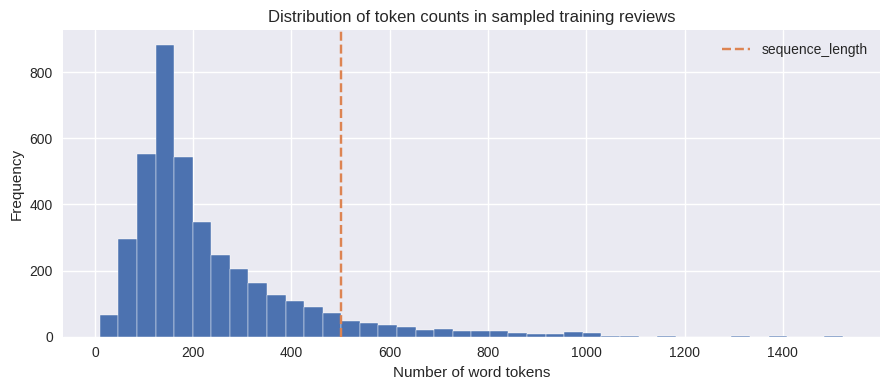

In [ ]:
# Splite the paragrpjahocs to avioid the review is too long
sequence_length = 500
sample_size = 4000 # From 20K total sample pick 4000 training sample

label_counts = Counter()
review_lengths = []


for text, label in raw_train_ds.unbatch().take(sample_size):
    label_counts[int(label.numpy())] += 1
    review_lengths.append(len(text.numpy().decode("utf-8").split()))
    ##print(text)
    ##print(text.numpy().decode("utf-8"))
    #sampletext = raw_train_ds.unbatch().take(1)
#print(text.numpy().decode("utf-8"))

print("Label distribution in first", sample_size, "training reviews:")
for idx, count in sorted(label_counts.items()):
    print(f"  {raw_train_ds.class_names[idx]}: {count}")

lengths = np.array(review_lengths)
coverage = (lengths <= sequence_length).mean() * 100
p90 = np.percentile(lengths, 90)
##print(f"Mean tokens: {lengths.mean():.1f} | Median: {np.median(lengths):.1f} | 90th percentile: {p90:.1f}")
##print(f"Chosen sequence_length covers {coverage:.1f}% of these reviews without truncation.")

plt.figure(figsize=(9, 4))
plt.hist(lengths, bins=40, color="#4c72b0", edgecolor="white")
plt.axvline(sequence_length, color="#dd8452", linestyle="--", label="sequence_length")
plt.title("Distribution of token counts in sampled training reviews")
plt.xlabel("Number of word tokens")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()

# Convert the sentences capitalletters, gmails, commas, pouctuation


### 1.5 Clean raw text with a custom standardization function

We now clean the text, adapt a TextVectorization layer, and look at the learned vocabulary. The IMDB files contain HTML break tags (`<br />`) and punctuation that we do not want the model to treat as standalone tokens. We therefore lowercase everything, strip HTML, and remove punctuation before tokenization.


In [ ]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    cleaned = tf.strings.regex_replace(
        no_html,
        f"[{re.escape(string.punctuation)}]",
        ""
    )
    return cleaned
print(re.escape(string.punctuation))
# Inside the string puntuation: !"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~
sample_text = tf.constant(["<br />Amazing film!!! Emotional AND funny."], dtype=tf.string)
print("Original text:", sample_text.numpy()[0].decode("utf-8"))
print("After custom_standardization:", custom_standardization(sample_text).numpy()[0].decode("utf-8"))


!"\#\$%\&'\(\)\*\+,\-\./:;<=>\?@\[\\\]\^_`\{\|\}\~
Original text: <br />Amazing film!!! Emotional AND funny.
After custom_standardization:  amazing film emotional and funny


TextVectorization learns the most frequent tokens from the training set and converts each cleaned review into a list of integer IDs. We cap the vocabulary at max_features = 20,000 tokens and pad or truncate every sequence to exactly sequence_length = 500 so later models can work with dense tensors.


In [ ]:
max_features = 20000 #??
# translate text into numerics integers
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features, # the maximum vocabarays 20k words, OOV out of order vocabulary (vacaburay really meaningless ouside of usage)
    output_mode="int", #numerics integers
    output_sequence_length=sequence_length,
)

print("Adapting TextVectorization layer (this scans the training text once)...")
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

vocab = vectorize_layer.get_vocabulary() # Vectorize the vocabuary, numerical vector embedding the characteristics,
print("Vocabulary size:", len(vocab))
print("Top 10 tokens:", vocab[:10])
print("Sample tokens 200-210:", vocab[200:210])


Adapting TextVectorization layer (this scans the training text once)...
Vocabulary size: 20000
Top 10 tokens: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('a'), np.str_('of'), np.str_('to'), np.str_('is'), np.str_('in'), np.str_('it')]
Sample tokens 200-210: [np.str_('series'), np.str_('gets'), np.str_('without'), np.str_('come'), np.str_('always'), np.str_('right'), np.str_('times'), np.str_('isnt'), np.str_('saw'), np.str_('long')]


### 1.6 See what vectorization produces for a sample review

To keep the process tangible, take a short sentence, vectorize it, and decode the first few non-zero IDs back to their tokens.


In [ ]:
sample_review = tf.constant([
    "This movie was AMAZING!!! <br /> Loved it from start to finish."
], dtype=tf.string)
vectorized = vectorize_layer(sample_review).numpy()[0]
non_zero_ids = vectorized[vectorized != 0][:15] # Extract from dictionay the ids non-zero
reconstructed_tokens = [vocab[idx] for idx in non_zero_ids] # Vocabary dictory the id integer

print("Original review:"
, sample_review.numpy()[0].decode("utf-8"))
print("First 15 token IDs:", non_zero_ids)
print("Decoded tokens:", reconstructed_tokens)


Original review: This movie was AMAZING!!! <br /> Loved it from start to finish.
First 15 token IDs: [  11   17   13  463  446    9   35  368    6 1323]
Decoded tokens: [np.str_('this'), np.str_('movie'), np.str_('was'), np.str_('amazing'), np.str_('loved'), np.str_('it'), np.str_('from'), np.str_('start'), np.str_('to'), np.str_('finish')]


### 1.7 Prepare fast input pipelines for later models

We wrap the vectorization logic inside `tf.data` pipelines so future models receive ready-to-use tensors. Caching and prefetching overlap CPU preprocessing with GPU training.


In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
# Cache through the total epoachs, keep all the vectors every run the epoches and batches when training CNNs
# prefetch 32 fetch (Mini batch) through the first epoch send 32 from CPU to GPU, multiple circulation and allowance on queue from CPU sent batches
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

example_batch = next(iter(train_ds.take(1)))
example_features, example_labels = example_batch
print("Vectorized batch shape:", example_features.shape)
print("Labels shape:", example_labels.shape)
print("First review token IDs (first 20 positions):", example_features[0][:20].numpy())


Vectorized batch shape: (32, 500)
Labels shape: (32,)
First review token IDs (first 20 positions): [   2    1    7    4   73 7844 4199  200  188 1397 2232    3    4   49
  111    8  695    1   71  821]


### 1.8 Embedding intuition: from sparse tokens to dense geometry

An embedding layer learns a dense vector for every token ID so that similar reviews receive similar representations. The heatmaps below show 12 token positions from three sample sentences mapped into a 128-dimensional space (colors represent the initial random values that future training will adjust).


Text(0.5, 0, 'Token position')

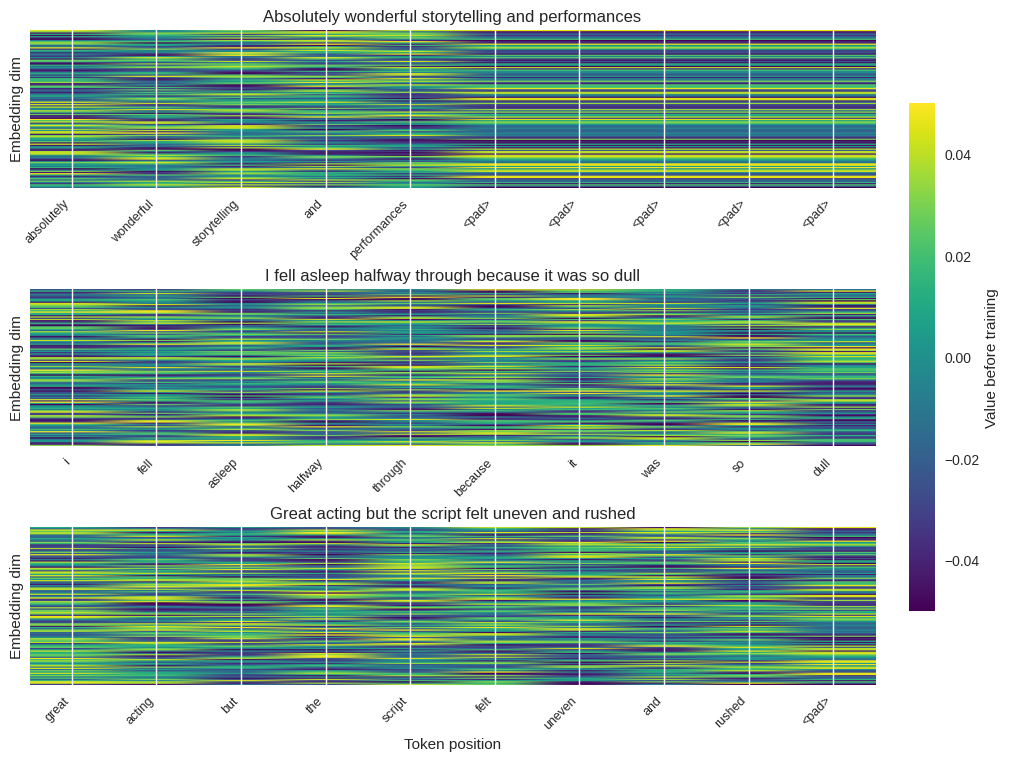

In [ ]:

embedding_dim = 128 # ?????Embedding Dimensions 128 , the size of image individual
num_positions = 10
embedding_demo_layer = tf.keras.layers.Embedding(
    input_dim=max_features,
    output_dim=embedding_dim,
    name="demo_embedding"
)

demo_sentences = tf.constant([
    "Absolutely wonderful storytelling and performances",
    "I fell asleep halfway through because it was so dull",
    "Great acting but the script felt uneven and rushed"
], dtype=tf.string)

demo_tokens = vectorize_layer(demo_sentences)[:, :num_positions]
demo_vectors = embedding_demo_layer(demo_tokens)
demo_texts = [text.decode("utf-8") for text in demo_sentences.numpy()]
demo_token_labels = []
for row in demo_tokens.numpy():
    tokens = [vocab[idx] if idx != 0 else "<pad>" for idx in row]
    demo_token_labels.append(tokens)

fig, axes = plt.subplots(
    len(demo_texts),
    1,
    figsize=(10, 2.5 * len(demo_texts)),
    constrained_layout=True,
)
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]

for ax, text, token_labels, vectors in zip(axes, demo_texts, demo_token_labels, demo_vectors):
    mat = vectors.numpy().T
    im = ax.imshow(mat, aspect="auto", cmap="viridis")
    ax.set_title(text)
    ax.set_ylabel("Embedding dim")
    ax.set_xticks(range(num_positions))
    ax.set_xticklabels(token_labels, rotation=45, ha="right", fontsize=9)
    ax.set_yticks([])

cbar = fig.colorbar(im, ax=axes, fraction=0.03, pad=0.04)
cbar.set_label("Value before training")
plt.xlabel("Token position")

# Zero padding: make the legthen of sentence into same size 500 euqualized and exactly
# Add fitted number of zeros into the input two sides

### 1.10 Function to visualize model training later on

We finish Part 1 by defining a small plotting helper that both the CNN and RNN will reuse. Keeping it here highlights that tooling for evaluation is part of the data-preparation story.


In [ ]:
def plot_history(history, title_prefix="Model"):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])
    epochs_range = range(1, len(acc) + 1)

    if acc:
        plt.figure()
        plt.plot(epochs_range, acc, label="Train acc")
        plt.plot(epochs_range, val_acc, label="Val acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title_prefix} Accuracy")
        plt.legend()
        plt.tight_layout()

    if loss:
        plt.figure()
        plt.plot(epochs_range, loss, label="Train loss")
        plt.plot(epochs_range, val_loss, label="Val loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{title_prefix} Loss")
        plt.legend()
        plt.tight_layout()


## Part 2 – Convolutional neural network for sentiment

With vectorized reviews in hand we can feed them into a convolutional neural network. A 1-D CNN slides filters across the embedded tokens to detect short phrases such as “not good” or “absolutely loved.” We follow the following:

1. Embed tokens into dense vectors that are learned jointly with the classifier.
2. Apply dropout and stacked Conv1D layers to capture n-gram evidence.
3. Use global max pooling to convert variable-length sequences into fixed-size representations.
4. Add dense layers and a sigmoid output for binary sentiment.

We train for a few epochs, inspect the learning curves, and wrap the model with the TextVectorization layer so it can accept raw strings just like any production API.



### 2.1 Connect vectorized reviews to convolution-friendly tensors

`train_ds` now yields padded sequences of token IDs with shape `(batch, sequence_length)`. Before building a full CNN it helps to confirm those shapes and see how an embedding layer turns each integer into a dense vector.


In [ ]:

cnn_example_tokens, cnn_example_labels = next(iter(train_ds.take(1)))
print("Vectorized batch:", cnn_example_tokens.shape)
print("Label batch:", cnn_example_labels.shape)

embedding_probe = tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_dim)
example_embeddings = embedding_probe(cnn_example_tokens[:1])
print("Embedding output shape for one review:", example_embeddings.shape)
print("First token ID:", int(cnn_example_tokens[0, 0]), "-> embedding vector (first 5 dims):", example_embeddings[0, 0, :5].numpy())
## Create the

Vectorized batch: (32, 500)
Label batch: (32,)
Embedding output shape for one review: (1, 500, 128)
First token ID: 11 -> embedding vector (first 5 dims): [ 0.00748187  0.00693588 -0.01225802 -0.00608359  0.00125281]



### 2.2 Build the CNN block by block

A 1-D CNN treats the sequence dimension like a spatial axis. We embed tokens, drop out some activations for regularization, stack two convolutional layers to detect meaningful n-grams, pool across time, and finish with dense layers. The `build_cnn_model` helper below keeps these decisions encapsulated so we can reuse the architecture later.


In [ ]:

def build_cnn_model(
    vocab_size=max_features,
    embed_dim=embedding_dim,
    conv_filters=256,
    kernel_size=5,
    dense_units=256, # Too large overfitting to noises, large capacity,
    dropout_rate=0.35,
    l2_reg=1e-4,
):
    inputs = tf.keras.Input(shape=(None,), dtype="int64", name="token_ids")
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, name="embedding")(inputs)
    x = tf.keras.layers.SpatialDropout1D(dropout_rate, name="dropout_emb")(x)
    reg = tf.keras.regularizers.l2(l2_reg)
    x = tf.keras.layers.Conv1D(
        filters=conv_filters,
        kernel_size=kernel_size,
        padding="same",
        activation="relu",
        kernel_regularizer=reg,
        name="conv1",
    )(x)
    x = tf.keras.layers.BatchNormalization(name="bn1")(x)
    x = tf.keras.layers.Conv1D(
        filters=conv_filters,
        kernel_size=kernel_size,
        padding="same",
        activation="relu",
        kernel_regularizer=reg,
        name="conv2",
    )(x)
    x = tf.keras.layers.BatchNormalization(name="bn2")(x)
    x = tf.keras.layers.GlobalMaxPooling1D(name="global_max_pool")(x)
    x = tf.keras.layers.Dense(
        dense_units,
        activation="relu",
        kernel_regularizer=reg,
        name="dense_hidden",
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate, name="dropout_hidden")(x)
    outputs = tf.keras.layers.Dense(
        1,
        activation="sigmoid",
        kernel_regularizer=reg,
        name="output",
    )(x)
    return tf.keras.Model(inputs, outputs, name="cnn_model")

cnn_model = build_cnn_model()
cnn_model.summary()


Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)          │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_emb (SpatialDropout1D)  │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv1D)                  │ (None, None, 256)      │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, None, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv1D)                  │ (None, None, 256)      │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, None, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pool                 │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_hidden (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,120,129 (11.90 MB)

 Trainable params: 3,119,105 (11.90 MB)

 Non-trainable params: 1,024 (4.00 KB)


### 2.3 Visualize how convolution windows slide across embeddings

Each `Conv1D` kernel looks at `kernel_size` consecutive tokens at a time. The heatmap below feeds one sample review through a toy convolutional layer (random weights) to illustrate how activations are produced across the sequence.


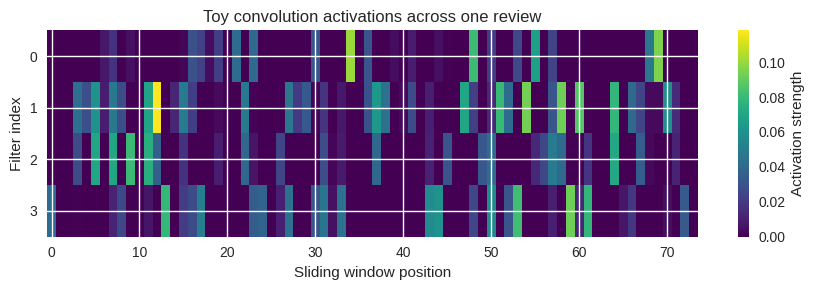

In [ ]:
conv_window = 7
conv_filters = 4
sample_tokens = cnn_example_tokens[:1, :80]
sample_embeddings = embedding_probe(sample_tokens)
conv_demo = tf.keras.layers.Conv1D(filters=conv_filters, kernel_size=conv_window, strides=1, activation="relu")
activations = conv_demo(sample_embeddings).numpy()[0].T  # (filters, steps)

plt.figure(figsize=(9, 3))
plt.imshow(activations, aspect="auto", cmap="viridis")
plt.colorbar(label="Activation strength")
plt.title("Toy convolution activations across one review")
plt.xlabel("Sliding window position")
plt.ylabel("Filter index")
plt.tight_layout()



### 2.4 Compile the CNN with binary cross-entropy and Adam

Sentiment analysis is a binary classification problem. We pair the sigmoid output with binary_crossentropy and monitor accuracy.


In [ ]:
cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
cnn_model.compile(
    loss="binary_crossentropy",
    optimizer=cnn_optimizer,
    metrics=["accuracy"],
)
print("CNN compiled and ready to train.")


CNN compiled and ready to train.



### 2.5 Train the CNN

We reuse the cached datasets from Part 1, train a bit longer with a reduce-on-plateau schedule, and call plot_history so the curves are adjacent to the training output.


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

cnn_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,  # less aggressive
        min_lr=1e-5,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=3,
        restore_best_weights=True,
        verbose=1,
    ),
]

history_cnn = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=cnn_callbacks,
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - accuracy: 0.5211 - loss: 0.8990 - val_accuracy: 0.6694 - val_loss: 0.6509 - learning_rate: 3.0000e-04
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 664s 1s/step - accuracy: 0.7694 - loss: 0.5345 - val_accuracy: 0.8722 - val_loss: 0.3692 - learning_rate: 3.0000e-04
Epoch 3/10
369/625 ━━━━━━━━━━━━━━━━━━━━ 4:09 975ms/step - accuracy: 0.8963 - loss: 0.3183


### 2.6 Peek at trained CNN embeddings

Replot the same sample sentences after CNN training to see how the embedding layer reshapes token vectors once it has learned from the data.


In [ ]:

cnn_embed_layer = cnn_model.get_layer("embedding")
cnn_sentences = tf.constant([
    "Absolutely wonderful storytelling and performances",
    "I fell asleep halfway through because it was so dull",
    "Great acting but the script felt uneven and rushed",
], dtype=tf.string)

cnn_tokens = vectorize_layer(cnn_sentences)[:, :num_positions]
cnn_token_labels = []
for row in cnn_tokens.numpy():
    tokens = [vocab[idx] if idx != 0 else "<pad>" for idx in row]
    cnn_token_labels.append(tokens)
cnn_vectors = cnn_embed_layer(cnn_tokens)

fig, axes = plt.subplots(
    len(cnn_sentences),
    1,
    figsize=(10, 2.5 * len(cnn_sentences)),
    constrained_layout=True,
)
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]

for ax, text, token_labels, vectors in zip(axes, cnn_sentences.numpy(), cnn_token_labels, cnn_vectors):
    mat = vectors.numpy().T  # (embedding_dim, num_positions)
    im = ax.imshow(mat, aspect="auto", cmap="viridis")
    ax.set_title(text.decode("utf-8"))
    ax.set_ylabel("Embedding dim")
    ax.set_xticks(range(num_positions))
    ax.set_xticklabels(token_labels, rotation=45, ha="right", fontsize=9)
    ax.set_yticks([])

cbar = fig.colorbar(im, ax=axes, fraction=0.03, pad=0.04)
cbar.set_label("CNN embedding value (post-training)")
plt.xlabel("Token position")



### 2.7 Evaluate on the held-out test set

After training, we compute the final test loss/accuracy.


In [ ]:

test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_ds)
print(f"CNN test loss: {test_loss_cnn:.4f}")
print(f"CNN test accuracy: {test_acc_cnn:.4f}")



### 2.8 Wrap preprocessing + model for raw-string inference

In practice we rarely receive pre-vectorized tensors. Wrapping the trained CNN with the TextVectorization layer gives us a single graph that accepts raw strings. The sanity-check predictions double as a demo for how to deploy the model later.

In [ ]:

cnn_inputs_str = tf.keras.Input(shape=(), dtype=tf.string, name="text")
cnn_indices = vectorize_layer(cnn_inputs_str)
cnn_outputs_str = cnn_model(cnn_indices)

cnn_end_to_end = tf.keras.Model(cnn_inputs_str, cnn_outputs_str, name="cnn_end_to_end")
cnn_end_to_end.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

sample_texts = [
    "I absolutely loved this movie. The acting was fantastic and the story was touching.",
    "This was the worst film I have seen in years. Boring and predictable.",
]
sample_texts_tensor = tf.constant(sample_texts, dtype=tf.string)
cnn_preds = cnn_end_to_end.predict(sample_texts_tensor)
for text, p in zip(sample_texts, cnn_preds):
    p_val = float(p.item())
    print(f"[CNN] {text!r} -> positive probability = {p_val:.3f}")


## Part 3 – Recurrent neural network for sentiment

Convolutions focus on local patterns. Recurrent networks reason about order explicitly by processing one token at a time and carrying information across the sequence. We build a bidirectional LSTM so the model can read the review forward and backward, capture dependencies that span many words, and then pass the final representation through dense layers. The training loop mirrors the CNN so we can compare apples to apples.



### 3.1 Review sequential inputs and token order

Recurrent networks read one token at a time, so order matters. The cell below inspects a vectorized batch, prints the decoded tokens for the first review, and reminds us that padding fills the tail with zeros.


In [ ]:

rnn_example_tokens, rnn_example_labels = next(iter(train_ds.take(1)))
print("Vectorized batch shape:", rnn_example_tokens.shape)
print("Label batch shape:", rnn_example_labels.shape)

first_review_ids = rnn_example_tokens[0][:20].numpy()
decoded_tokens = [vocab[idx] for idx in first_review_ids if idx != 0]
print("First 20 token IDs:", first_review_ids)
print("Decoded tokens (truncated at first pad token):", decoded_tokens)
print("Label:", int(rnn_example_labels[0].numpy()))



### 3.2 Build the bidirectional LSTM sentiment model

We embed the input sequence, apply dropout, pass it through a bidirectional LSTM (64 units in each direction), and finish with dense layers. The forward/backward combination lets the network reason about both preceding and following context for every token.


In [ ]:

def build_rnn_model(
    vocab_size=max_features,
    embed_dim=embedding_dim,
    lstm_units=128,
    dense_units=256,
    dropout_rate=0.35,
    recurrent_dropout=0.2,
    l2_reg=1e-4,
):
    inputs = tf.keras.Input(shape=(None,), dtype="int64", name="token_ids")
    x = tf.keras.layers.Embedding(vocab_size, embed_dim, name="embedding")(inputs)
    x = tf.keras.layers.Dropout(dropout_rate, name="dropout_emb")(x)
    reg = tf.keras.regularizers.l2(l2_reg)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            lstm_units,
            return_sequences=False,
            dropout=recurrent_dropout,
            kernel_regularizer=reg,
            recurrent_regularizer=reg,
        ),
        name="bilstm",
    )(x)
    x = tf.keras.layers.Dense(
        dense_units,
        activation="relu",
        kernel_regularizer=reg,
        name="dense_hidden",
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate, name="dropout_hidden")(x)
    outputs = tf.keras.layers.Dense(
        1,
        activation="sigmoid",
        kernel_regularizer=reg,
        name="output",
    )(x)
    return tf.keras.Model(inputs, outputs, name="rnn_model")

rnn_model = build_rnn_model()
rnn_model.summary()



### 3.3 Peek at hidden-state dynamics across the sequence

To build intuition, we feed one review through a lightweight bidirectional LSTM with `return_sequences=True` and plot the hidden activations along the time axis. Unlike the CNN heatmap, these activations depend on everything the network has seen so far.


In [ ]:

demo_length = 60
demo_embedding = tf.keras.layers.Embedding(max_features, 32)
demo_bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True))

demo_tokens = rnn_example_tokens[:1, :demo_length]
demo_vectors = demo_embedding(demo_tokens)
demo_states = demo_bilstm(demo_vectors).numpy()[0].T  # shape: (2*16, steps)

plt.figure(figsize=(10, 3))
plt.imshow(demo_states, aspect="auto", cmap="coolwarm")
plt.colorbar(label="Hidden activation")
plt.title("Bidirectional LSTM hidden states across one review")
plt.xlabel("Token position")
plt.ylabel("Hidden dimension")
plt.tight_layout()



### 3.4 Compile the RNN with binary cross-entropy

Sentiment is still a binary label, so we reuse the sigmoid + binary_crossentropy combination and monitor accuracy.


In [ ]:

rnn_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

rnn_model.compile(
    loss="binary_crossentropy",
    optimizer=rnn_optimizer,
    metrics=["accuracy"],
)
print("RNN compiled and ready to train.")



### 3.5 Train the RNN and compare curves to the CNN

Training mirrors Part 2 with the same epoch budget and learning-rate schedule as the CNN so the comparison is apples to apples. Plotting the history right after fitting makes it easier to contrast convergence behavior.


In [ ]:
rnn_epochs = 3
rnn_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=1,
        min_lr=1e-5,
        verbose=1,
    ),
    tf.keras.callbacks.EarlyStopping(# The Early Stopping is not necessary,
        patience=2,
        monitor="val_loss",
        restore_best_weights=True,
        verbose=1,
    ),
]
history_rnn = rnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=rnn_epochs,
    callbacks=rnn_callbacks,
)

plot_history(history_rnn, "RNN (BiLSTM)")


### 3.6 Peek at trained RNN embeddings

Replot the same sample sentences after RNN training to compare how the BiLSTM embedding layer arranges token vectors.

In [ ]:

rnn_embed_layer = rnn_model.get_layer("embedding")
rnn_sentences = tf.constant([
    "Absolutely wonderful storytelling and performances",
    "I fell asleep halfway through because it was so dull",
    "Great acting but the script felt uneven and rushed",
], dtype=tf.string)

rnn_tokens = vectorize_layer(rnn_sentences)[:, :num_positions]
rnn_token_labels = []
for row in rnn_tokens.numpy():
    tokens = [vocab[idx] if idx != 0 else "<pad>" for idx in row]
    rnn_token_labels.append(tokens)
rnn_vectors = rnn_embed_layer(rnn_tokens)

fig, axes = plt.subplots(
    len(rnn_sentences),
    1,
    figsize=(10, 2.5 * len(rnn_sentences)),
    constrained_layout=True,
)
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]

for ax, text, token_labels, vectors in zip(axes, rnn_sentences.numpy(), rnn_token_labels, rnn_vectors):
    mat = vectors.numpy().T  # (embedding_dim, num_positions)
    im = ax.imshow(mat, aspect="auto", cmap="viridis")
    ax.set_title(text.decode("utf-8"))
    ax.set_ylabel("Embedding dim")
    ax.set_xticks(range(num_positions))
    ax.set_xticklabels(token_labels, rotation=45, ha="right", fontsize=9)
    ax.set_yticks([])

cbar = fig.colorbar(im, ax=axes, fraction=0.03, pad=0.04)
cbar.set_label("RNN embedding value (post-training)")
plt.xlabel("Token position")



### 3.7 Evaluate on the test set

We keep track of test_acc_rnn so the comparison section can place the CNN and RNN side by side.


In [ ]:

test_loss_rnn, test_acc_rnn = rnn_model.evaluate(test_ds)
print(f"RNN test loss: {test_loss_rnn:.4f}")
print(f"RNN test accuracy: {test_acc_rnn:.4f}")
# The accuracy is lower than the CNN, less time training , and make the task binary , and simple er

782/782 ━━━━━━━━━━━━━━━━━━━━ 317s 406ms/step - accuracy: 0.8730 - loss: 0.3705
RNN test loss: 0.3696
RNN test accuracy: 0.8724



### 3.8 Wrap the RNN for raw-text inference

Just like we did for the CNN, we prepend the TextVectorization layer so the model accepts raw strings. These quick predictions double as a demo for practical usage.


In [ ]:

rnn_inputs_str = tf.keras.Input(shape=(), dtype=tf.string, name="text")
rnn_indices = vectorize_layer(rnn_inputs_str)
rnn_outputs_str = rnn_model(rnn_indices)

rnn_end_to_end = tf.keras.Model(rnn_inputs_str, rnn_outputs_str, name="rnn_end_to_end")
rnn_end_to_end.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    metrics=["accuracy"],
)

sample_texts = [
    "I absolutely loved this movie. The acting was fantastic and the story was touching.",
    "This was the worst film I have seen in years. Boring and predictable.",
]
sample_texts_tensor = tf.constant(sample_texts, dtype=tf.string)
rnn_preds = rnn_end_to_end.predict(sample_texts_tensor)
for text, p in zip(sample_texts, rnn_preds):
    p_val = float(p.item())
    print(f"[RNN] {text!r} -> positive probability = {p_val:.3f}")



## Part 4 – Compare the CNN and RNN

Numbers alone rarely tell the whole story. This final section reuses the helper utilities to:
- print test accuracies side by side for both neural models,
- visualize loss/accuracy curves, and
- compare CNN vs. RNN predictions on the same sample reviews.


### 4.1 Summarize headline metrics (two models)

We start by printing test metrics for the CNN and the BiLSTM so you have a quantitative snapshot before discussing dynamics or qualitative behavior.


In [ ]:
print(f"CNN test accuracy                       : {test_acc_cnn:.4f}")
print(f"RNN test accuracy                       : {test_acc_rnn:.4f}")

# Identify leader among the two
scores = {
    "CNN": test_acc_cnn,
    "RNN": test_acc_rnn,
}
leader_name = max(scores, key=scores.get)
leader_score = scores[leader_name]
runner_up = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[1]
print(f"Leader: {leader_name} | accuracy: {leader_score:.4f} | gap: {leader_score - runner_up[1]:.4f}")



### 4.2 Compare training dynamics visually

In [ ]:

plot_history(history_cnn, "CNN")
plot_history(history_rnn, "RNN (BiLSTM)")



### 4.3 Qualitative predictions on the same reviews

Numbers alone rarely reveal *how* the models disagree. We therefore feed the same reviews to each end-to-end model and print the predicted positive probabilities.


In [ ]:
comparison_texts = [
    "The movie started off slow but eventually became very emotional and powerful.",
    "I fell asleep in the middle. The plot was dull and the acting terrible.",
    "Not bad, but not great either. Some scenes were really good, others felt pointless.",
]
comparison_tensor = tf.constant(comparison_texts, dtype=tf.string)

cnn_probs = cnn_end_to_end.predict(comparison_tensor)
rnn_probs = rnn_end_to_end.predict(comparison_tensor)

print("\n======================================")
print(" Sample prediction comparison (0–1)  ")
print("======================================")
for text, pc, pr in zip(comparison_texts, cnn_probs, rnn_probs):
    print(f"Review: {text}")
    print(f"  CNN positive probability: {float(pc):.3f}")
    print(f"  RNN positive probability: {float(pr):.3f}")
    print("-" * 60)



### 4.4 Discussions

- Which architecture gives higher validation accuracy? Does the difference persist on the test set?
- Do the learning curves reveal overfitting or faster convergence for one model?
- When predictions diverge, is it because of long-range structure (favoring RNNs) or local phrases (favoring CNNs)?

#### Takeaways and next steps

- We built a full NLP pipeline: raw IMDB text → custom preprocessing → reusable datasets that feed directly into neural architectures.
- Two complementary models (CNN and BiLSTM).
- Try extending the analysis by changing the vocabulary size, adjusting sequence length, adding pretrained embeddings, or experimenting with transformers to see how the comparison evolves. See https://keras.io/examples/nlp/text_classification_with_transformer/.
